In [1]:
from IPython.display import Image


In [2]:
# Figure 1 DATA
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400)

In [3]:
# Figure 2 GOAL
Image(url= "https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

In [4]:
# Figure 3
Image(url= "https://www.cntk.ai/jup/logistic_neuron.jpg", width=300, height=200)

In [5]:

# Import the relevant components
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable

In [9]:
# Define the network
input_dim = 2
num_output_classes = 2

In [8]:
# Ensure that we always get the same results
np.random.seed(0)

# Helper function to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data using NumPy.
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)

    # Make sure that the data is separable
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)

    # Specify the data type to match the input variable used later in the tutorial
    # (default type is double)
    X = X.astype(np.float32)

    # convert class 0 into the vector "1 0 0",
    # class 1 into the vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    Y = np.asarray(np.hstack(class_ind), dtype=np.float32)
    return X, Y

In [10]:
# Create the input variables denoting the features and the label data. Note: the input
# does not need additional info on the number of observations (Samples) since CNTK creates only
# the network topology first
mysamplesize = 32
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes)

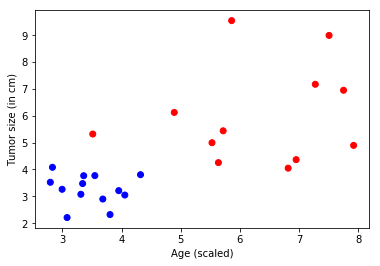

In [32]:
# Plot the data
import matplotlib.pyplot as plt
%matplotlib inline

# let 0 represent malignant/red and 1 represent benign/blue
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]

plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()

In [12]:
# Figure 4
Image(url= "https://www.cntk.ai/jup/logistic_neuron2.jpg", width=300, height=200)

In [13]:
feature = C.input_variable(input_dim, np.float32)

In [14]:
# Define a dictionary to store the model parameters
mydict = {}

def linear_layer(input_var, output_dim):

    input_dim = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dim, output_dim))
    bias_param = C.parameter(shape=(output_dim))

    mydict['w'], mydict['b'] = weight_param, bias_param

    return C.times(input_var, weight_param) + bias_param

In [15]:
output_dim = num_output_classes
z = linear_layer(feature, output_dim)

In [16]:
label = C.input_variable(num_output_classes, np.float32)
loss = C.cross_entropy_with_softmax(z, label)

In [17]:
eval_error = C.classification_error(z, label)

In [21]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, eval_error), [learner])

In [18]:
# Define a utility function to compute the moving average.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=10):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Define a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss, eval_error = "NA", "NA"

    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))

    return mb, training_loss, eval_error

In [19]:
# Initialize the parameters for the trainer
minibatch_size = 25
num_samples_to_train = 20000
num_minibatches_to_train = int(num_samples_to_train  / minibatch_size)

In [22]:
from collections import defaultdict

# Run the trainer and perform model training
training_progress_output_freq = 50
plotdata = defaultdict(list)

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)

    # Assign the minibatch data to the input variables and train the model on the minibatch
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i,
                                                     training_progress_output_freq, verbose=1)

    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 0.6931, Error: 0.44
Minibatch: 50, Loss: 2.8413, Error: 0.32
Minibatch: 100, Loss: 0.4632, Error: 0.16
Minibatch: 150, Loss: 1.6383, Error: 0.48
Minibatch: 200, Loss: 0.2867, Error: 0.08
Minibatch: 250, Loss: 0.1914, Error: 0.12
Minibatch: 300, Loss: 0.2032, Error: 0.08
Minibatch: 350, Loss: 0.3896, Error: 0.16
Minibatch: 400, Loss: 0.2346, Error: 0.08
Minibatch: 450, Loss: 0.8076, Error: 0.24
Minibatch: 500, Loss: 0.9285, Error: 0.36
Minibatch: 550, Loss: 0.3296, Error: 0.20
Minibatch: 600, Loss: 0.7978, Error: 0.24
Minibatch: 650, Loss: 0.0495, Error: 0.00
Minibatch: 700, Loss: 0.9855, Error: 0.28
Minibatch: 750, Loss: 0.3842, Error: 0.12


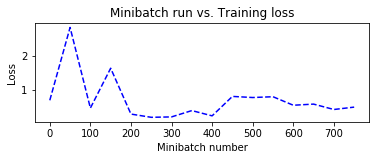

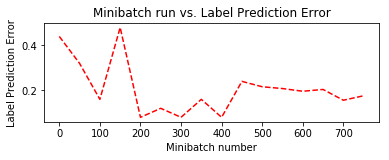

In [25]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()


In [24]:
# Run the trained model on a newly generated dataset
test_minibatch_size = 25
features, labels = generate_random_data_sample(test_minibatch_size, input_dim, num_output_classes)

trainer.test_minibatch({feature : features, label : labels})

0.04

In [26]:
out = C.softmax(z)
result = out.eval({feature : features})

In [27]:
print("Label    :", [np.argmax(label) for label in labels])
print("Predicted:", [np.argmax(x) for x in result[0]])

Label    : [1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]
Predicted: [0, 0]


[ 7.91541576 -7.91541243]


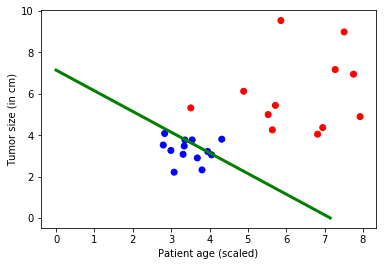

In [38]:

# Model parameters
print(mydict['b'].value)

bias_vector   = mydict['b'].value
weight_matrix = mydict['w'].value

# Plot the data
import matplotlib.pyplot as plt

# let 0 represent malignant/red, and 1 represent benign/blue
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]
plt.scatter(features[:,0], features[:,1], c=colors)
plt.plot([0, bias_vector[0]/weight_matrix[0][1]],
         [ bias_vector[1]/weight_matrix[0][0], 0], c = 'g', lw = 3)
plt.xlabel("Patient age (scaled)")
plt.ylabel("Tumor size (in cm)")
plt.show()